In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgcm
import sectionate
import xarray as xr
import numpy as np
import matplotlib.pylab as plt

# Computing velocity-grid following sections with `sectionate`

In this example, we use the `sectionate.grid_section` function to find the grid cell indices for the series of grid cell faces that best approximate a hydrographic section input by the user. In this case, we consider both the West and East sections of the *Overturning of the Subpolar North Atlantic (OSNAP)* observational program.

We consider both cases of the memory MOM6 memory models: symmetric (excluding the cell faces at the western and southern edges of the domain; also used in MOM5 and the MITgcm C-grids) and non-symmetric (including all tracer cell faces).

## 1. Symmetric grid example (CM2-MOM5)

### Load the model grid

In [3]:
ds = xr.open_dataset('grid_CM2_minimal.nc')
coords={
    'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
    'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
}
grid = xgcm.Grid(ds, coords=coords, boundary={"X":"periodic", "Y":"periodic"}, autoparse_metadata=False)

### Define section start, end, and some intermediate points to capture the general structure

In [4]:
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]

Behind the scenes, `sectionate.create_section_composite` iterates through each of the consecutive linear segments in the section and uses `sectionate.create_section` to approximate them with the closest series of consecutive points on the vorticity grid (i.e. following the cell faces on which velocities are defined).

In [5]:
iwest,jwest,xwest,ywest = sectionate.grid_section(
    grid,
    West_section_lons,
    West_section_lats,
    topology="MOM-tripolar"
)

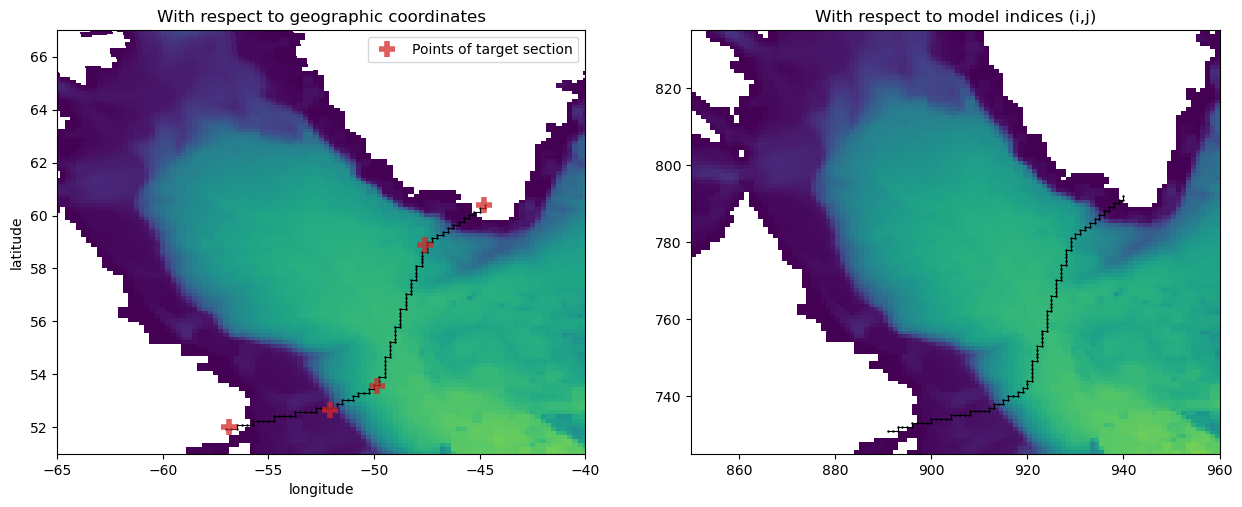

In [6]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(ds['geolon_t'], ds['geolat_t'], ds['ht'][1::,1::])
plt.plot(xwest, ywest, 'k.-', markersize=1.5, lw=0.75)
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=12., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(ds['ht'].values)
plt.plot(iwest, jwest, 'k.-', markersize=1.5, lw=0.75)
plt.axis([850,960, 725, 835])
plt.title("With respect to model indices (i,j)")
plt.show()

In [7]:
uvindices = sectionate.uvindices_from_qindices(grid, iwest, jwest)
lons, lats = sectionate.uvcoords_from_uvindices(
    grid,
    uvindices,
)

#### Section orientation metadata

We keep track of the orientation of each section by noting whether . The default orientation is such that a closed section will be clockwise when viewed from the south pole stereographic projection.

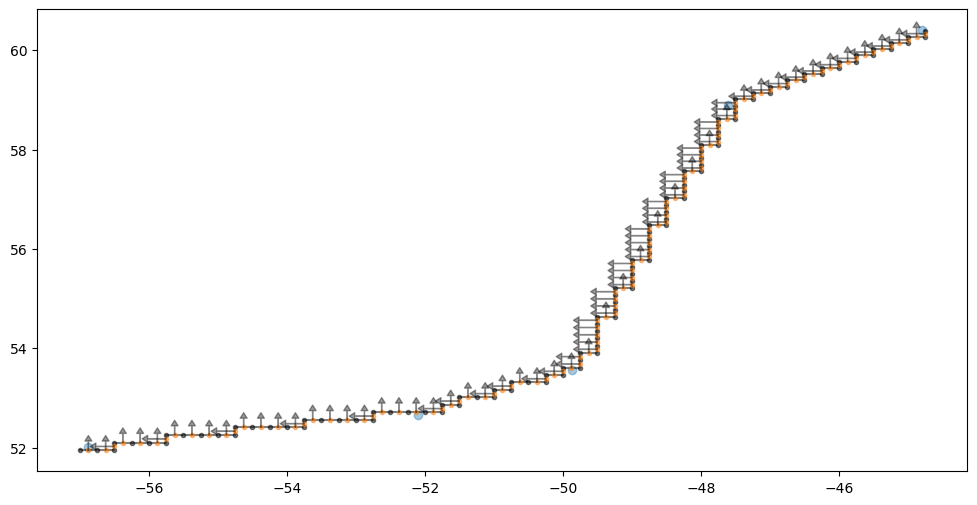

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(West_section_lons, West_section_lats, "C0o", alpha=0.4)
for (p, (var, lon, lat, nward, eward)) in enumerate(zip(uvindices['var'], lons, lats, uvindices['nward'], uvindices['eward'])):
    if var=="V":
        efact = 0.
        nfact = -1 if not(eward) else 1
    if var=="U":
        efact = -1 if nward else 1
        nfact = 0.

    plt.annotate('', xy=(lon+float(efact)*0.35, lat+float(nfact)*0.3),  xycoords='data',
            xytext=(lon, lat),
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.25, headwidth=5., headlength=4., alpha=0.4),
            horizontalalignment='center', verticalalignment='center')
plt.plot(xwest, ywest, "ko-", alpha=0.5, markersize=3, label="tracer cell corners (vorticity grid)")
plt.plot(lons, lats, "C1o", alpha=0.5, lw=1, markersize=3, label="velocity cells (faces normal to section)");

## 2. Non-symmetric grid example (CM4-MOM6)

### Load the model grid

In [9]:
from example_dataset_grids import load_CM4p25
grid = load_CM4p25()
ds = grid._ds

### Define section start, end, and some intermediate points to capture the general structure

In [10]:
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]
East_section_lats=[60.3000, 58.8600, 58.0500, 58.0000, 56.5000]
East_section_lons=[-44.9000, -30.5400, -28.0000, -14.7000, -5.9300]

We iterate on each linear segment of the section to better follow the path of the ship. We use `sectionate.create_section` to find the path of adjacent tracer cell indices that most closely follow each segment. The sub-sections for each linear segment are then appended to common arrays to build the full section.

**Note:** the last point of a segment is removed to not duplicate the first point of the following segment.



In [11]:
iwest,jwest,xwest,ywest = sectionate.grid_section(
    grid,
    West_section_lons,
    West_section_lats,
    topology="MOM-tripolar"
)

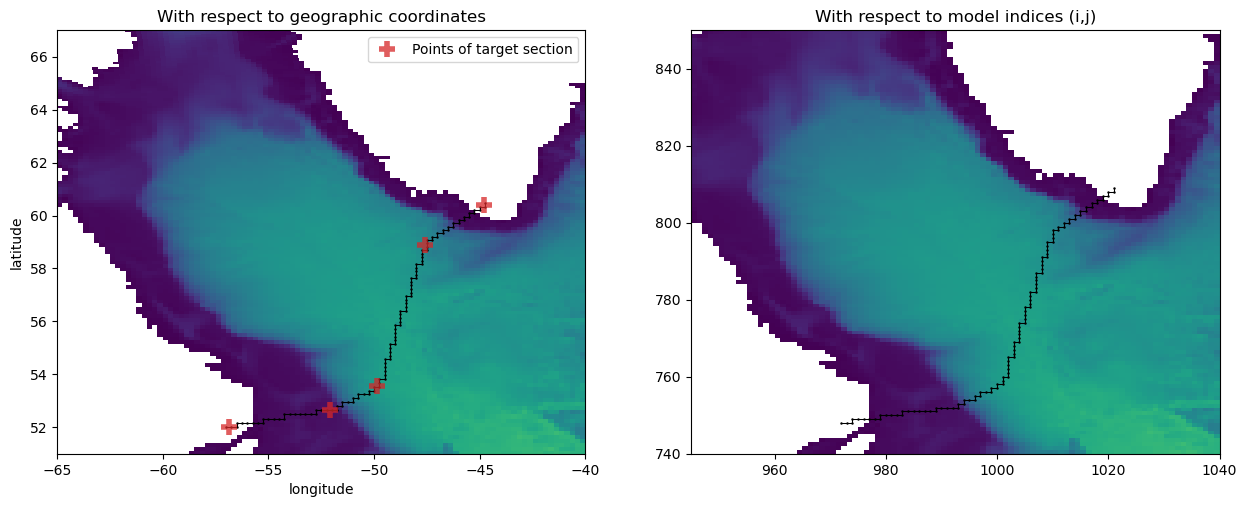

In [12]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(ds['geolon_c'], ds['geolat_c'], ds['deptho'].where(ds['deptho']!=0))
plt.plot(xwest, ywest, 'k.-', markersize=1.5, lw=0.75)
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=12., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(ds['deptho'].where(ds['deptho']!=0).values)
plt.plot(iwest, jwest, 'k.-', markersize=1.5, lw=0.75)
plt.axis([945, 1040, 740, 850])
plt.title("With respect to model indices (i,j)")
plt.show()

In [13]:
uvindices = sectionate.uvindices_from_qindices(grid, iwest, jwest)
lons, lats = sectionate.uvcoords_from_uvindices(
    grid,
    uvindices
)

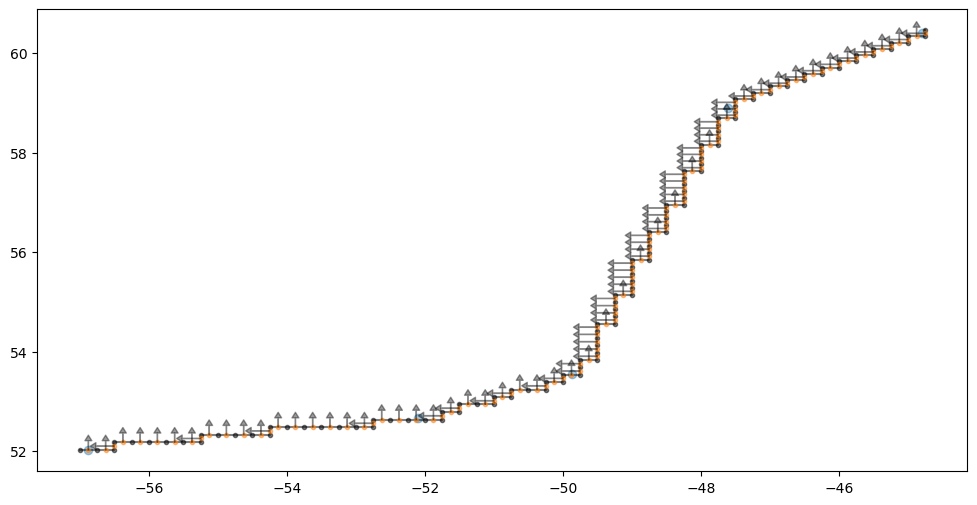

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(West_section_lons, West_section_lats, "C0o", alpha=0.4)
for (p, (var, lon, lat, nward, eward)) in enumerate(zip(uvindices['var'], lons, lats, uvindices['nward'], uvindices['eward'])):
    if var=="V":
        efact = 0.
        nfact = -1 if not(eward) else 1
    if var=="U":
        efact = -1 if nward else 1
        nfact = 0.

    plt.annotate('', xy=(lon+float(efact)*0.35, lat+float(nfact)*0.3),  xycoords='data',
            xytext=(lon, lat),
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.25, headwidth=5., headlength=4., alpha=0.4),
            horizontalalignment='center', verticalalignment='center')
plt.plot(xwest, ywest, "ko-", alpha=0.5, markersize=3, label="tracer cell corners (vorticity grid)")
plt.plot(lons, lats, "C1o", alpha=0.5, lw=1, markersize=3, label="velocity cells (faces normal to section)");